Question1 

In [1]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np 

In [2]:
#Defining variables
u1 = cp.Variable()
u2 = cp.Variable()
#Defining Parameter
theta = cp.Parameter(nonneg = True)
d = [3.5, 2]
# d = [2, 1]
# Defining the objective function
objectiveW = cp.Maximize(u1*theta + u2*(1-theta))
# Defining the constraints
Wconstraints = [u1 + 2*u2 -12<= 0, 2*u1 + u2 -12 <=0,  -u1 + d[0]<= 0, -u2 + d[1]<= 0]
optimumU = []
thetaValues = np.linspace(0, 1, 100)
# Calculating optimum value at diff values of theta
for i in thetaValues:
    theta.value = i
    Optimization = cp.Problem(objectiveW, Wconstraints)
    result = Optimization.solve()
    optimumU.append(u1.value)




Plotting the graph

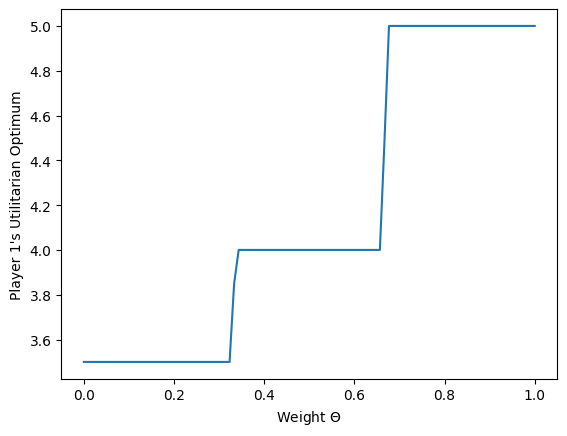

In [3]:
plt.plot(thetaValues, optimumU)
plt.xlabel('Weight $\Theta$')
plt.ylabel('Player 1\'s Utilitarian Optimum')
plt.show()

Question 2a

In [4]:
# Defining Nash Welfare function
objectiveN = cp.Maximize(cp.log(u1-d[0]) + cp.log(u2-d[1]))
# Using cvxpy library functions to solve the optimization problem
Optimization = cp.Problem(objectiveN, Wconstraints)
answer = Optimization.solve()
print("Primal optimal value: ", answer)
for i in range(len(Wconstraints)):
    print(f"Dual value of constraint {i}: {Wconstraints[i].dual_value}")
print("u1 and u2 for Nash bargaining solution are ", u1.value, u2.value)

Primal optimal value:  0.11778302005591901
Dual value of constraint 0: 3.6170408140313444e-09
Dual value of constraint 1: 0.6666667548200322
Dual value of constraint 2: 3.202879721090295e-09
Dual value of constraint 3: 1.5363574774749631e-09
u1 and u2 for Nash bargaining solution are  4.249999934669844 3.5000001072596256


Question 2b

In [5]:
d1Values = np.linspace(2, 5, 100)
optimumU1Values = []
optimumU2Values = []
for i in range(len(d1Values)):
    Nconstraints = [u1 + 2*u2 -12<= 0, 2*u1 + u2 -12 <=0, -u1 <= 0, -u2 <= 0, -u1 + d1Values[i]<= 0, -u2 + 2<= 0]
    objectiveN = cp.Maximize(cp.log(u1-d1Values[i]) + cp.log(u2-2))
    Optimization = cp.Problem(objectiveN, Nconstraints)
    Optimization.solve()
    optimumU1Values.append(u1.value)
    optimumU2Values.append(u2.value)


Plotting the graph

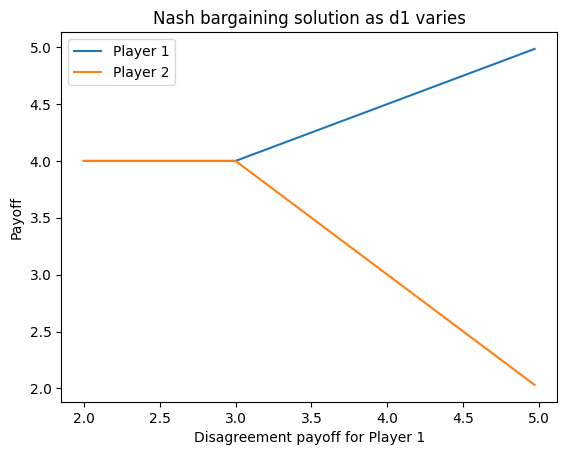

In [6]:
plt.plot(d1Values, optimumU1Values, label='Player 1')
plt.plot(d1Values, optimumU2Values, label='Player 2')
plt.title('Nash bargaining solution as d1 varies')
plt.xlabel('Disagreement payoff for Player 1')
plt.ylabel('Payoff')
plt.legend()
plt.show()

Question3

In [10]:
# Interior Point Algorithm
import numdifftools as nd
import numpy as np
import math

# Defining all constraints as functions
def constraint1(x):
    if x[0] + 2 * x[1] >= 12:
        return -1e30
    else:
        return -np.log(-(x[0] + 2 * x[1] - 12))

def constraint2(x):
    if 2 * x[0] + x[1] >= 12:
        return -1e30
    else:
        return -np.log(-(2 * x[0] + x[1] - 12))

def constraint3(x):
    if x[0] <= 2:
        return -1e30
    else:
        return -np.log(-(2 - x[0]))

def constraint4(x):
    if x[1] <= 1:
        return -1e30
    else:
        return -np.log(-(1 - x[1]))
# Defining the nash function
def f(x):
  if x[1] <= 1 or x[0] <= 2:
     return 1e30
  return -(np.log(x[0]-2) + np.log(x[1]-1))
# Defining the objective function
def g(x, t):
  return t*f(x) -constraint1(x) - constraint2(x) - constraint3(x) -constraint4(x)

def modGrad(func, x, t):
  y = nd.Gradient(func)(x,t)
  return (y[0]**2 + y[1]**2)**0.5

# Define the Gradient of the barrier function using numdifftools
def grad_g(x, t):
    return nd.Gradient(lambda x: g(x, t))(x)

# Define the Hessian of the barrier function using numdifftools
def hess_g(x, t):
    return nd.Hessian(lambda x: g(x, t))(x)

# Using line search algorithim to calculate the step size
def lineSearchAlgo(func, t1,alpha, beta, x, d):
  i = 0
  t = 1
  while(func(x, t1) - func(np.add(x, t*d), t1)) < (-1)*alpha*((np.dot(nd.Gradient(func)(x, t1), t*d)) and i < 100):
    t = t*beta
    i += 1
  return t  

def newtonDescent(func, x, t1, eta):
  i = 0
  while(modGrad(func, x, t1) > eta and i < 100):
    # print("loop")
    d = -np.matmul(np.linalg.inv(hess_g(x, t1)), grad_g(x, t1)) 
    t = lineSearchAlgo(func, t1, 0.3, 0.8, x, d)
    x_next = x + t*d
    # print("n")
    if 2*x_next[0] + x_next[1] - 12 >= 0 or x_next[0] + 2*x_next[1] - 12 >= 0 or 2 - x_next[0] >= 0 or 1 - x_next[1] >= 0:
      print("Infeasible point found!")
      # print(1)
      x_next[0] = x_next[0] - 0.05
      x_next[1] = x_next[1] - 0.05
      print(modGrad(func, x, t1) > eta and i < 100)
    
    x = x_next
    i += 1
    # print("returning value", i, x)
    return x

def InteriorPointAlgorithm(func, x, t1, mu, m, eta):
    while(m/t1 > eta):
        t1 = mu*t1
        xT = newtonDescent(func, x, t1, 1e-5)
        print(xT)
        if 2*xT[0] + xT[1] - 12 >= 0 or xT[0] + 2*xT[1] - 12 >= 0 or 2 - xT[0] >= 0 or 1 - xT[1] >= 0:
          print("Infeasible point found")
          break
        print(xT, t1)
        x = xT
    u1 = x[0]
    u2 = x[1]
    Wconstraints = [u1 + 2*u2 -12, 2*u1 + u2 -12 ,  -u1 + 2, -u2 + 1]
    print("Primal Optimum solution: ", x)
    print("Final t : ", t1)
    print("Nash bargaining solution : ", -f(x))
    print("Dual Variable 1 : ", -1/(t1*Wconstraints[0]))
    print("Dual Variable 2 : ", -1/(t1*Wconstraints[1]))
    print("Dual Variable 3 : ", -1/(t1*Wconstraints[2]))
    print("Dual Variable 4 : ", -1/(t1*Wconstraints[3]))
    print("Value of ineuality 1 ", Wconstraints[0])
    print("Value of ineuality 2 ", Wconstraints[1])
    print("Value of ineuality 3 ", Wconstraints[2])
    print("Value of ineuality 4 ", Wconstraints[3])

InteriorPointAlgorithm(g, [3.7, 3.4], 1, 15, 4, 1e-5)

[3.68977476 3.37869514]
[3.68977476 3.37869514] 15
[4.00230598 3.82972005]
[4.00230598 3.82972005] 225
[4.04596922 3.89058456]
[4.04596922 3.89058456] 3375
[4.04596922 3.89058456]
[4.04596922 3.89058456] 50625
[4.04596922 3.89058456]
[4.04596922 3.89058456] 759375
Primal Optimum solution:  [4.04596922 3.89058456]
Final t :  759375
Nash bargaining solution :  1.7773303777131642
Dual Variable 1 :  7.618071564296491e-06
Dual Variable 2 :  7.534892616769546e-05
Dual Variable 3 :  6.436423445405078e-07
Dual Variable 4 :  4.5557305086025465e-07
Value of ineuality 1  -0.17286165099253026
Value of ineuality 2  -0.017476989984604785
Value of ineuality 3  -2.0459692236744402
Value of ineuality 4  -2.8905845626665148


Primal optimal value:  1.7917594473733116
Dual value of constraint 0: 0.055555492917319045
Dual value of constraint 1: 0.22222225382821226
Dual value of constraint 2: 2.6347836197701797e-09
Dual value of constraint 3: 1.8187904014581112e-09
u1 and u2 for Nash bargaining solution are  4.000000004979701 3.9999999269662188